In [15]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.formatter.limits'] = (-2,4)
import pymaster as nmt
import tqdm
import sys
sys.path.insert(0,'../')
import xgal
from tqdm.auto import trange

cmap = mpl.cm.YlOrRd
cmap.set_over(cmap(1.))
cmap.set_under('w')
cmap.set_bad('gray')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Parameters

In [16]:
nside = 512
nbar = 100. # gal per pixel, a lot more than actual DES redmagic

b = nmt.NmtBin(nside, nlb=16)
ell_b = b.get_effective_ells()

lmax = b.lmax #3*nside - 1 #1000
nlb = 16

nbar_str = nbar / hp.nside2pixarea(nside, degrees=False)
print ("nbar = %g galaxies/arcmin^2"%(nbar_str*(np.pi/(180*60))**2))

shotnoise = 1. / nbar_str

aposize = 5. * hp.nside2resol(nside, arcmin=True) / 60. #2.0
apotype = 'C1'

nbar = 2.11818 galaxies/arcmin^2


# Load inputs

## gg power spectrum computed with CCL (see demo).

In [17]:
ell, cls_in = np.loadtxt('cls_gg.txt', unpack=True)
ell = ell[:lmax+1]
cls_in = cls_in[:lmax+1]

(1, 1535)

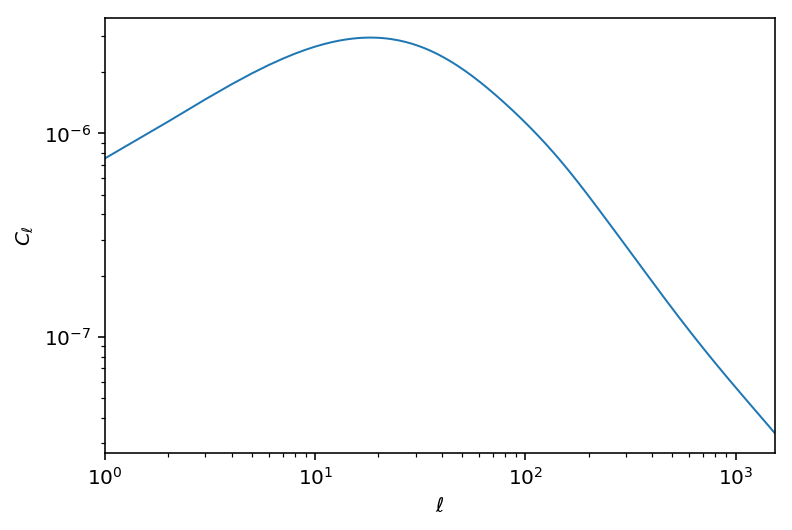

In [18]:
plt.loglog(ell, cls_in)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.xlim(1,lmax)

## mask and completeness

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


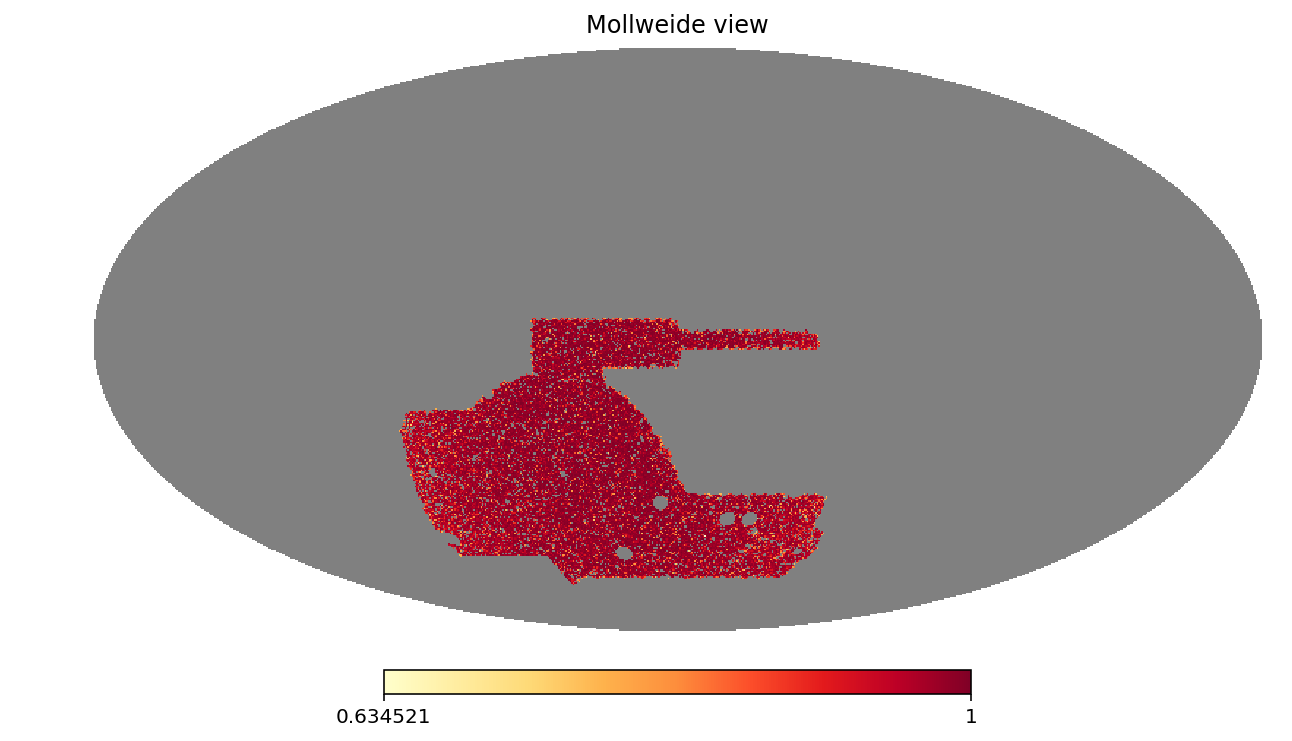

In [19]:
mask_frac = hp.read_map('../../masks/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_lgt20_vl02_FRACGOOD_nside%i.fits'%nside)
hp.mollview(mask_frac, cmap=cmap)

In [20]:
# Just to avoid issues later
completeness = mask_frac
completeness[completeness == hp.UNSEEN] = 0.0

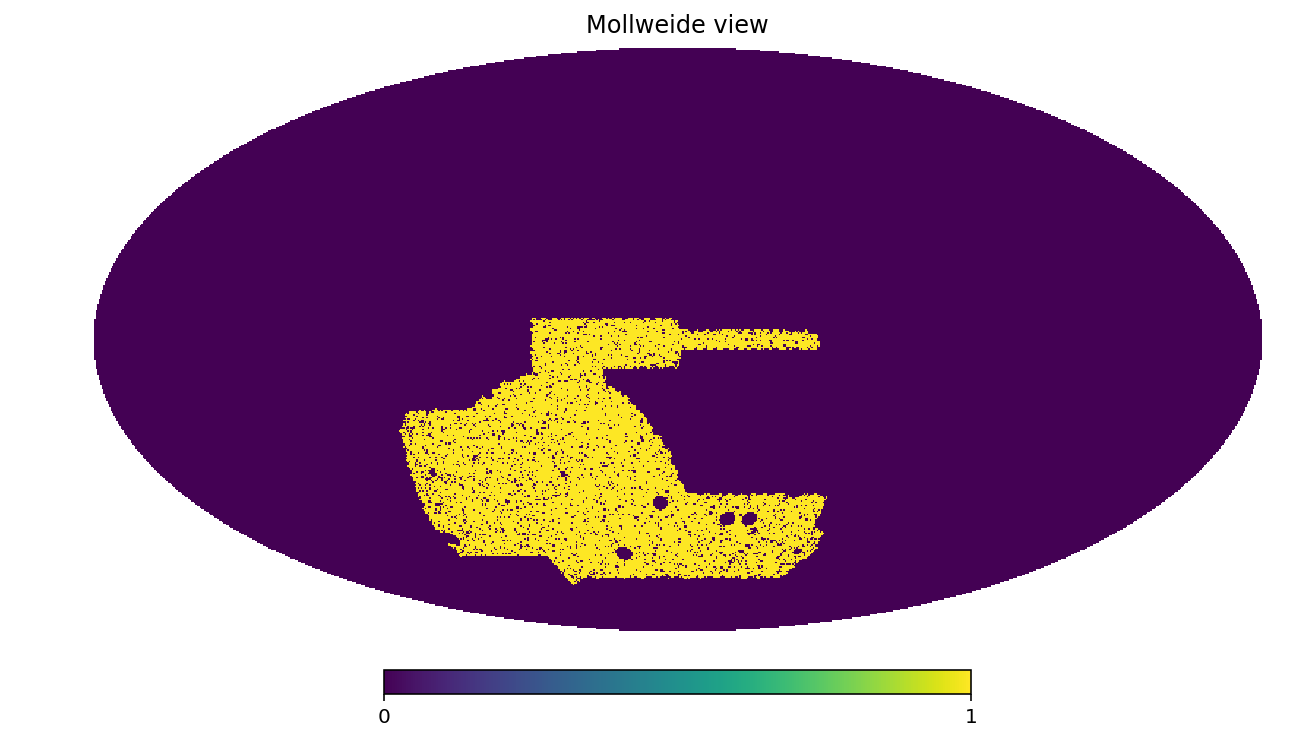

In [21]:
mask = (mask_frac > 0.)
hp.mollview(mask)

## Apodize the binary mask

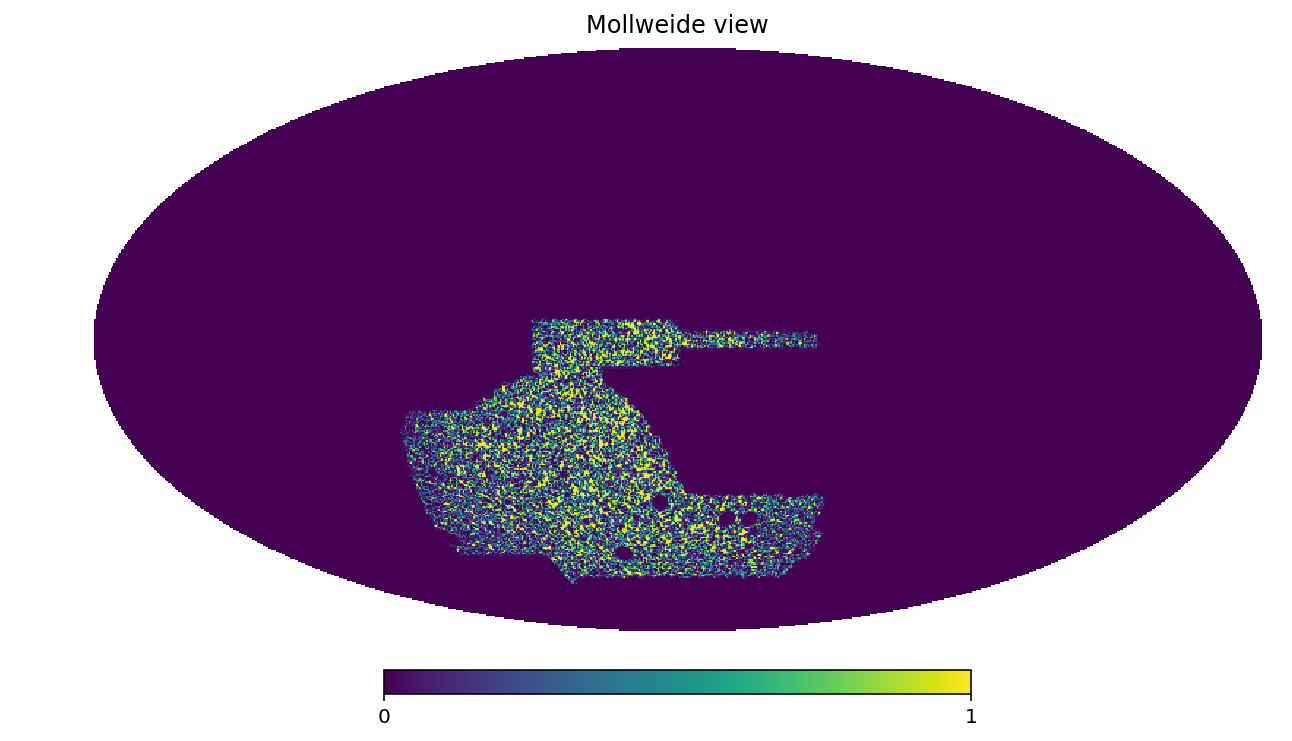

In [22]:
mask_apo = nmt.mask_apodization(mask, aposize=aposize, apotype=apotype)
hp.mollview(mask_apo)

# Test pipeline

In [9]:
# Build workspace

_field = nmt.NmtField(mask_apo, [mask_apo])

wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(_field, _field, b)

In [9]:
def generate_cls_test(cls_in, mask, completeness, workspace, b, use_comp_for_random=False):
    # Generate random gaussian debsity
    density_in = hp.synfast(cls_in, nside, lmax=lmax, verbose=False)
    density_in[np.logical_not(mask)] = hp.UNSEEN
    
    # Poisson sampling
    count = xgal.deltag.density2count(density_in, nbar, mask=mask, completeness=completeness, pixel=True)
    
    # Reconstruct density
    density_out = xgal.deltag.count2density(count, mask=mask, completeness=completeness)
    
    # Shuffle position
    count_r = xgal.deltag.get_random_count(count, completeness if use_comp_for_random else mask)
    density_r = xgal.deltag.count2density(count_r, mask=mask, completeness=completeness if use_comp_for_random else mask)
    
    # Make field objects
    field_in = nmt.NmtField(mask_apo, [density_in])
    field_out = nmt.NmtField(mask_apo, [density_out])
    field_r = nmt.NmtField(mask_apo, [density_r])
    
    # Compute spectra
    cls_test = []
    cls_test.append(nmt.compute_full_master(field_in, field_in, b, workspace=workspace))
    cls_test.append(nmt.compute_full_master(field_out, field_out, b, workspace=workspace))
    cls_test.append(nmt.compute_full_master(field_r, field_r, b, workspace=workspace))
    
    return np.array(cls_test)[:,0,:]

In [14]:
nsample = 128

cls_test = np.array([generate_cls_test(cls_in, mask, completeness, wsp, b, use_comp_for_random=False) for _ in trange(nsample)])

In [39]:
np.save('cls_test.npy', cls_test)

In [23]:
cls_test = np.load('cls_test.npy')

In [24]:
cls_test.shape

(128, 3, 95)

In [25]:
# Compute noise spectrum and subtract from out
cls_r = np.mean(cls_test[:,2,:],axis=0)
cls_test[:,1,:] -= cls_r

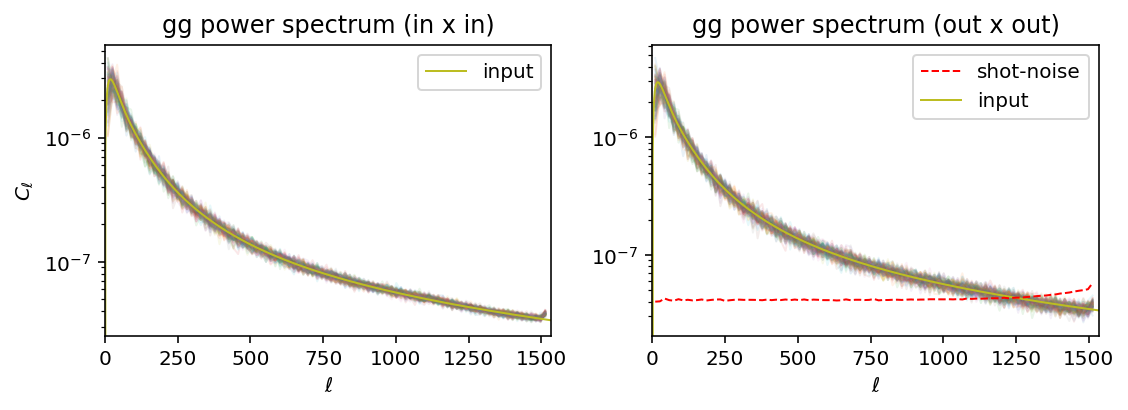

In [26]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
labels = ['in x in', 'out x out']
axes[1].plot(ell_b, cls_r, c='r', ls='--', label='shot-noise', zorder=32)
for i in range(2):
    ax = axes[i]
    for j in range(cls_test.shape[0]):
        ax.plot(ell_b, cls_test[j,i,:], alpha=.1, lw=1)
    ax.plot(ell, cls_in, label='input')
    ax.set_yscale('log')
    ax.set_title('gg power spectrum (%s)'%labels[i])
    ax.set_xlabel('$\\ell$')
    ax.set_xlim(0, b.lmax)
    ax.legend()
axes[0].set_ylabel('$C_\\ell$')
plt.tight_layout()

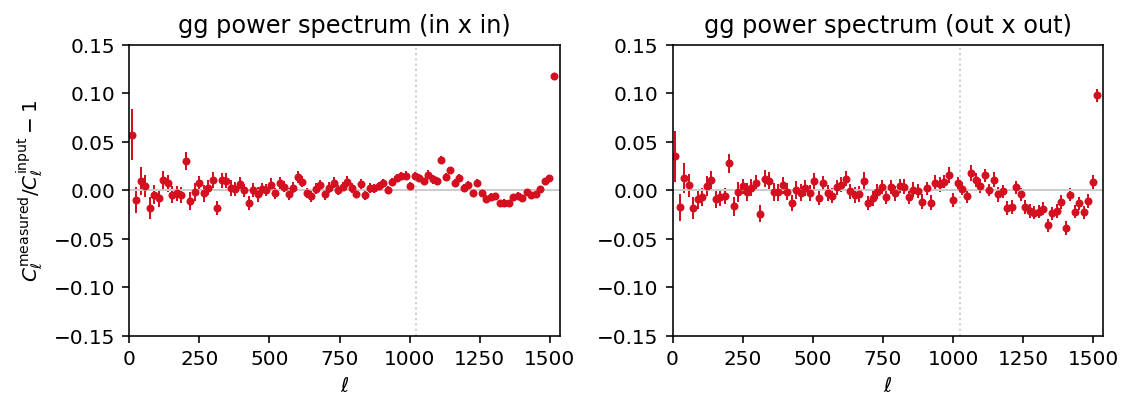

In [28]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
labels = ['in x in', 'out x out']

cls_in_b = b.bin_cell(cls_in)

ylim = 0.15

for i in range(2):
    ax = axes[i]
    m = np.mean(cls_test[:,i,:], axis=0)/cls_in_b-1.
    s = np.std(cls_test[:,i,:], axis=0)/cls_in_b/ np.sqrt(cls_test.shape[0])
    ax.errorbar(ell_b, m, s, color=mpl.cm.YlOrRd(0.8), ls=' ', marker='o', markersize=3)
    ax.axhline(y=0, c='0.8')
    ax.set_title('gg power spectrum (%s)'%labels[i])
    ax.set_xlabel('$\\ell$')
    ax.set_xlim(0, b.lmax)
    ax.set_ylim(-ylim,+ylim)
    ax.axvline(x=2*nside, ls=':', c='0.8')
axes[0].set_ylabel('$C_\\ell^{\\rm measured} / C_\\ell^{\\rm input} - 1$')
plt.tight_layout()

In [29]:
from fastkde import fastKDE

def truc(X,Ys):
    pxy, (xx,yy) = fastKDE.conditional(np.hstack(Ys), np.tile(X, Ys.shape[0]))
    xx_mask = (xx>np.min(X)) & (xx<np.max(X))
    yy_mask = (yy>np.min(Ys)) & (yy<np.max(Ys))
    xx = xx[xx_mask]
    yy = yy[yy_mask]
    pxy = pxy[np.ix_(yy_mask, xx_mask)]
    plt.contourf(xx, yy, pxy, 256, cmap=mpl.cm.gist_heat_r)
    plt.plot(xx, yy[np.argmax(pxy, axis=0)], c='w', lw=1, ls='--')

Text(0, 0.5, '$C_\\ell^{\\rm measured} / C_\\ell^{\\rm input} - 1$')

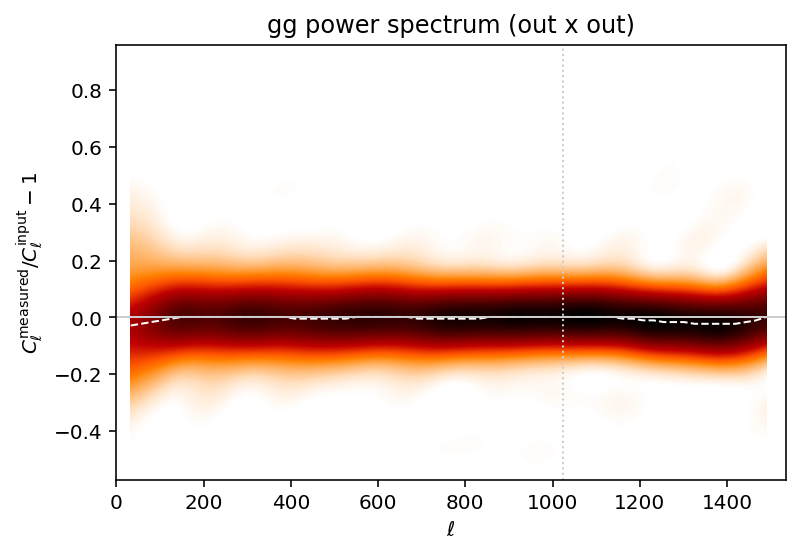

In [33]:
truc(ell_b, cls_test[:,1,:]/cls_in_b-1.)

plt.axhline(y=0, c='0.8')
plt.axvline(x=2*nside, ls=':', c='0.8')

plt.title('gg power spectrum (%s)'%labels[i])
plt.xlim(0, b.lmax)
# plt.ylim(-ylim,+ylim)
plt.xlabel('$\\ell$')
plt.ylabel('$C_\\ell^{\\rm measured} / C_\\ell^{\\rm input} - 1$')

